In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
# Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_PRESSURE LEVELS.nc').metpy.parse_cf()
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 37, time: 1)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2016-08-14T06:00:00
    metpy_crs  object Projection: latitude_longitude
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-29 15:33:43 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [3]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude.data
lons = ds.longitude.data

# Get the change in grid points
xx, yy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Select and grab data
geop = ds['z'] 
geop_w_units = geop * units('m ** 2 / s ** 2')
z = mpcalc.geopotential_to_height(geop_w_units)
uwnd = ds['u']
vwnd = ds['v']
vort = ds['vo']

# Select and grab 300-hPa geopotential heights and wind components, smooth with gaussian_filter.
vort_300 = gaussian_filter(vort.sel(level=300).data[0], sigma=3.0) * units('1/s')
hght_300 = gaussian_filter(z.sel(level=300).data[0], sigma=2.0) * units('m')
hght_dam = hght_300.to(units.decameter) #dam units
uwnd_300 = uwnd.sel(level=300).data[0] * units('m/s')
vwnd_300 = vwnd.sel(level=300).data[0] * units('m/s')
uwnd_300sm = gaussian_filter(uwnd_300, sigma=3.0) * units('m/s')
vwnd_300sm = gaussian_filter(vwnd_300, sigma=3.0) * units('m/s')

# Calculate the wind speed for streamline, change units from m/s to knots
sped_300 = mpcalc.wind_speed(uwnd_300, vwnd_300).to('kt')

# Create a clean datetime object for plotting based on time of the dataset
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

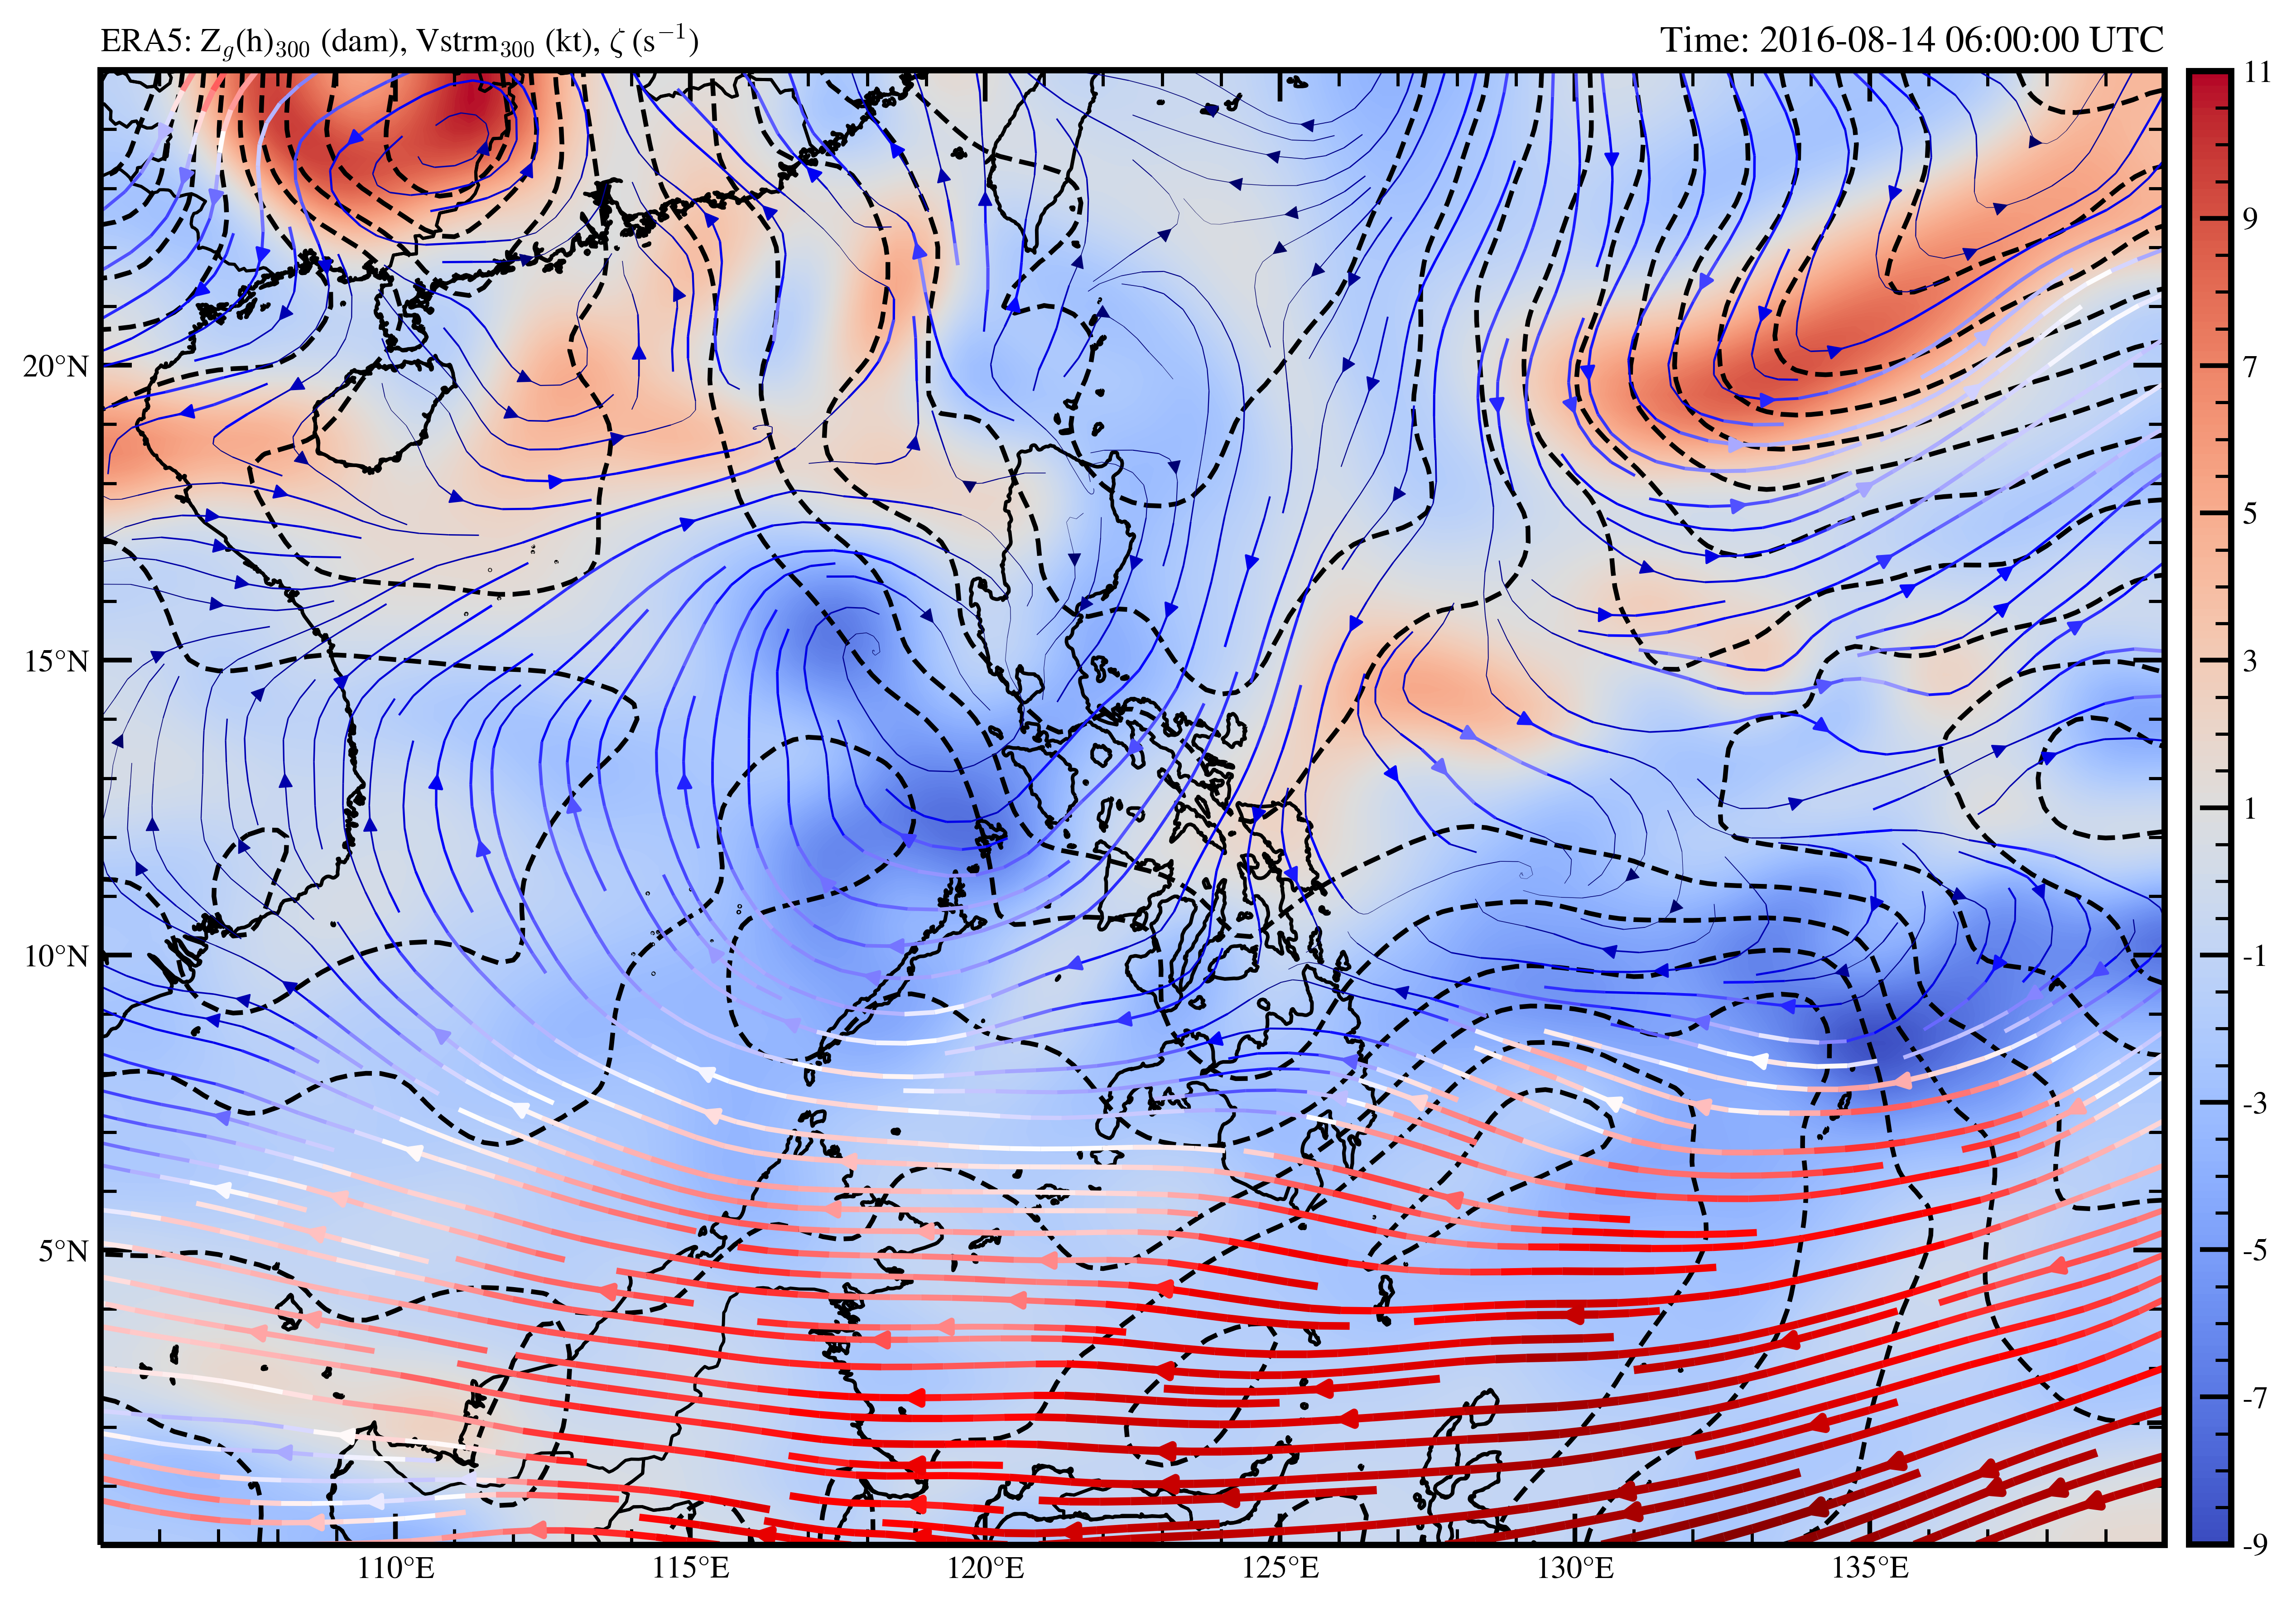

In [5]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 300-hPa Geopotential Heights in decameters
clevs_300_hght = np.arange(968, 974, 0.5) # For 500-hPa
cs = ax.contour(lons, lats, hght_dam, clevs_300_hght, colors='k', linestyles='--', 
                transform=datacrs)

# Streamline Analysis
speed = np.array(sped_300)
n = np.clip(speed, 0, 60) #limit
lw = 3*speed / n.max()

strm = ax.streamplot(lons, lats, uwnd_300.to('kt').m, vwnd_300.to('kt').m, 
                     density =[2.25, 2.25], color = n, transform=datacrs, 
                     cmap = "seismic", linewidth=lw)

clev_avor = np.arange(-0.000090, 0.000110, 0.000001)
cf = ax.contourf(lons, lats, vort_300, clev_avor, cmap='coolwarm', 
                 transform=datacrs)
cbar = plt.colorbar(cf, orientation='vertical', pad=0.01, aspect=35, shrink=0.542, 
                    ticks=[-0.000090,-0.000070,-0.000050,-0.000030,-0.000010,0.000010,
                           0.000030, 0.000050, 0.000070, 0.000090, 0.000110])
cbar.ax.set_yticklabels(['-9', '-7', '-5', '-3', '-1', 
                         '1', '3', '5', '7', '9', '11'])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5: Z$_{g}$(h)$_{300}$ (dam), Vstrm$_{300}$ (kt), $\zeta$ (s$^{-1}$)', 
          loc='left', fontsize=10.5)
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:7]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:5]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('GPM, STRM, RelVort.jpg', bbox_inches="tight")
plt.show()